In [1]:
import os

mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.1.0-posix-seh-rt_v5-rev1\\mingw64\\bin'

os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
plotly.offline.init_notebook_mode(connected=True)
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from pandas.tseries.offsets import *
%matplotlib inline

In [3]:
pd.set_option("display.max_rows", 10000)
pd.set_option("display.max_columns", 10000)


# 1.特徴量作る

trainとtestまとめて特徴量作る 

In [4]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
compose = pd.concat((train,test),axis=0)
compose = compose.reset_index().copy()
print(train.shape)
print(test.shape)
#print(compose.shape)
#print(compose)

(2101, 6)
(365, 5)


日付関連

In [5]:
compose.loc[:,"timestamp"] = pd.to_datetime(compose.loc[:,"datetime"])
compose.loc[:,"year"] = compose["timestamp"].apply(lambda x:x.year)
compose.loc[:,"month"] = compose["timestamp"].apply(lambda x:x.month)
compose.loc[:,"day"] = compose["timestamp"].apply(lambda x:x.day)
compose.loc[:,"weekday"] = compose["timestamp"].apply(lambda x:x.dayofweek)
compose.loc[:,"elapsed_days"] = compose.loc[:,"timestamp"].apply(lambda x:(x-compose.loc[0,"timestamp"]).days)
print(compose.shape)

(2466, 13)


https://www.jpm.jp/marketdata/　の成約数（datetimeの去年のデータを使うようにする）

In [6]:
period = ["2009b","2010u","2010b","2011u","2011b","2012u","2012b",
          "2013u","2013b","2014u","2014b","2015u","2015b","2016u","2016b"]
tintai_di = [-14.0,-21.6,-10.8,-4.2,10.4,16.6,31.1,4.1,16.8,9.9,24.5,15.8,13.8,14.9,26.3]
baibai_di = [-21.9,-15.8,1.8,6.4,4.7,9.0,17.1,10.9,26.5,21.9,31.4,17.8,18.7,18.6,23.5]

In [7]:
tintai_di_b = []
for i in range(0,len(tintai_di),2):
    tintai_di_b.append(tintai_di[i])
tintai_di_u = []
for i in range(1,len(tintai_di),2):
    tintai_di_u.append(tintai_di[i])
baibai_di_b = []
for i in range(0,len(baibai_di),2):
    baibai_di_b.append(baibai_di[i])
baibai_di_u = []
for i in range(1,len(baibai_di),2):
    baibai_di_u.append(baibai_di[i])
tintai_di_b_cum = pd.Series(tintai_di_b).cumsum()
tintai_di_u_cum = pd.Series(tintai_di_u).cumsum()
baibai_di_u_cum = pd.Series(baibai_di_u).cumsum()
baibai_di_b_cum = pd.Series(baibai_di_b).cumsum()
p_dict ={}
for  (p,t,b) in zip(period,tintai_di,baibai_di):
    p_dict[p] =(t,b)

In [8]:
#p_dict

In [9]:
def period_mapping(datetime):
    if ((pd.to_datetime("2008-10-01")<datetime) & (datetime<=pd.to_datetime("2009-3-31"))):
        return("2008b")
    elif ((pd.to_datetime("2009-3-31")<datetime) & (datetime<=pd.to_datetime("2009-9-30"))):
        return("2009u")
    elif ((pd.to_datetime("2009-9-30")<datetime) & (datetime<=pd.to_datetime("2010-3-31"))):
        return("2009b")
    elif ((pd.to_datetime("2010-3-31")<datetime) & (datetime<=pd.to_datetime("2010-9-30"))):
        return("2010u")
    elif ((pd.to_datetime("2010-9-30")<datetime) & (datetime<=pd.to_datetime("2011-3-31"))):
        return("2010b")
    elif ((pd.to_datetime("2011-3-31")<datetime) & (datetime<=pd.to_datetime("2011-9-30"))):
        return("2011u")
    elif ((pd.to_datetime("2011-9-30")<datetime) & (datetime<=pd.to_datetime("2012-3-31"))):
        return("2011b")
    elif ((pd.to_datetime("2012-3-31")<datetime) & (datetime<=pd.to_datetime("2012-9-30"))):
        return("2012u")
    elif ((pd.to_datetime("2012-9-30")<datetime) & (datetime<=pd.to_datetime("2013-3-31"))):
        return("2012b")
    elif ((pd.to_datetime("2013-3-31")<datetime) & (datetime<=pd.to_datetime("2013-9-30"))):
        return("2013u")
    elif ((pd.to_datetime("2013-9-30")<datetime) & (datetime<=pd.to_datetime("2014-3-31"))):
        return("2013b")
    elif ((pd.to_datetime("2014-3-31")<datetime) & (datetime<=pd.to_datetime("2014-9-30"))):
        return("2014u")
    elif ((pd.to_datetime("2014-9-30")<datetime) & (datetime<=pd.to_datetime("2015-3-31"))):
        return("2014b")
    elif ((pd.to_datetime("2015-3-31")<datetime) & (datetime<=pd.to_datetime("2015-9-30"))):
        return("2015u")
    elif ((pd.to_datetime("2015-9-30")<datetime) & (datetime<=pd.to_datetime("2016-3-31"))):
        return("2015b")
    elif ((pd.to_datetime("2016-3-31")<datetime) & (datetime<=pd.to_datetime("2016-9-30"))):
        return("2016u")
    elif ((pd.to_datetime("2016-9-30")<datetime) & (datetime<=pd.to_datetime("2017-3-31"))):
        return("2016b")

In [10]:
compose.loc[:,"period"] = (compose.loc[:,"timestamp"]).apply(lambda x:period_mapping(x))
compose.head()

,index,client,close,datetime,price_am,price_pm,y,timestamp,year,month,day,weekday,elapsed_days,period
0,0,0,0,2010-07-01,-1,-1,17.0,2010-07-01,2010,7,1,3,0,2010u
1,1,0,0,2010-07-02,-1,-1,18.0,2010-07-02,2010,7,2,4,1,2010u
2,2,0,0,2010-07-03,-1,-1,20.0,2010-07-03,2010,7,3,5,2,2010u
3,3,0,0,2010-07-04,-1,-1,20.0,2010-07-04,2010,7,4,6,3,2010u
4,4,0,0,2010-07-05,-1,-1,14.0,2010-07-05,2010,7,5,0,4,2010u


In [11]:
compose.loc[:,"period"] = (compose.loc[:,"timestamp"]).apply(lambda x:period_mapping(x))
#compose.head()

In [12]:
di_tuple = compose.loc[:,"period"].map(p_dict)
compose.loc[:,"tintai_bi"] = di_tuple.map(lambda x:x[0])
compose.loc[:,"baibai_di"] = di_tuple.map(lambda x:x[1])
print(compose.shape)
#compose.head()

(2466, 16)


関東労働力

In [13]:
period1 = ["2010Q1","2010Q2","2010Q3","2010Q4"
          ,"2011Q1","2011Q2","2011Q3","2011Q4" ,"2012Q1","2012Q2","2012Q3","2012Q4"
          ,"2013Q1","2013Q2","2013Q3","2013Q4","2014Q1","2014Q2","2014Q3","2014Q4"
          ,"2015Q1","2015Q2","2015Q3","2015Q4","2016Q1","2016Q2","2016Q3","2016Q4"
          ,"2017Q1","2017Q2","2017Q3","2017Q4","2018Q1"]
ibaragi = [1535,1561,1560,1554,1533,1560,1553,1546,
           1522,1547,1540,1533,1506,1532,1527,1522,
           1503,1536,1534,1528,1505,1533,1530,1523,
           1504,1532,1527,1520,1500,1527,1518,1513,1491]

totigi =  [1060,1089,1079,1069,1058,1083,1072,1064,
           1054,1079,1068,1055,1045,1070,1060,1047,
           1041,1071,1062,1050,1040,1066,1057,1044,
           1037,1064,1055,1042,1034,1061,1049,1037,1029]

gunma =   [1020,1054,1053,1039,1024,1053,1048,1033,
           1017,1043,1045,1028,1010,1036,1039,1022,
           1007,1040,1043,1025,1006,1034,1034,1018,
           1004,1031,1035,1018,1002,1032,1032,1015,997]

saitama =[3778,3860,3904,3875,3820,3872,3889,3870,
          3793,3843,3834,3817,3743,3779,3795,3781,
          3710,3766,3789,3784,3729,3796,3814,3816,
          3776,3842,3849,3864,3803,3848,3874,3893,3832]

tiba = [3265,3327,3320,3284,3270,3324,3319,3291,
       3274,3309,3298,3274,3268,3316,3308,3280,
       3271,3312,3308,3286,3275,3315,3306,3287,
        3282,3324,3312,3292,3294,3339,3342,3326,3306]

tokyo =[7227,7370,7350,7312,7330,7419,7322,7410,
        7460,7529,7323,7385,7402,7506,7407,7345,
        7431,7581,7433,7512,7534,7732,7560,7646,
        7582,7774,7718,7716,7634,7765,7803,7869,7795]

kanagawa =[4804,4792,4778,4739,4769,4798,4780,4763,
          4717,4789,4775,4769,4770,4777,4689,4759,
          4870,4808,4743,4773,4773,4775,4900,4825,
          4784,4816,4870,4797,4908,4973,4944,4897,4946]

total =[22699,23053,23044,22872,22804,23109,22983,22977,
        22837,23139,22883,22861,22744,23016,22825,22756,
        22833,23114,22912,22958,22862,23251,23201,23159,
        22969,23383,23366,23249,23175,23545,23562,23550,23396]

In [14]:
kanto_dict ={}
for  (p,ibaragi,totigi,gunma,saitama,tiba,tokyo,kanagawa,total) in zip(period1,ibaragi,totigi,gunma,saitama,tiba,tokyo,kanagawa,total):
    kanto_dict[p] =(ibaragi,totigi,gunma,saitama,tiba,tokyo,kanagawa,total)

In [15]:
def period1_mapping(datetime):
    if ((pd.to_datetime("2009-1-1")<=datetime) & (datetime<=pd.to_datetime("2009-3-31"))):
        return("2009Q1")
    elif ((pd.to_datetime("2009-3-31")<datetime) & (datetime<=pd.to_datetime("2009-6-30"))):
        return("2009Q2")
    elif ((pd.to_datetime("2009-6-30")<datetime) & (datetime<=pd.to_datetime("2009-9-30"))):
        return("2009Q3")
    elif ((pd.to_datetime("2009-9-30")<datetime) & (datetime<=pd.to_datetime("2009-12-31"))):
        return("2009Q4")
    elif ((pd.to_datetime("2010-1-1")<=datetime) & (datetime<=pd.to_datetime("2010-3-31"))):
        return("2010Q1")
    elif ((pd.to_datetime("2010-3-31")<datetime) & (datetime<=pd.to_datetime("2010-6-30"))):
        return("2010Q2")
    elif ((pd.to_datetime("2010-6-30")<datetime) & (datetime<=pd.to_datetime("2010-9-30"))):
        return("2010Q3")
    elif ((pd.to_datetime("2010-9-30")<datetime) & (datetime<=pd.to_datetime("2010-12-31"))):
        return("2010Q4")
    elif ((pd.to_datetime("2011-1-1")<=datetime) & (datetime<=pd.to_datetime("2011-3-31"))):
        return("2011Q1")
    elif ((pd.to_datetime("2011-3-31")<datetime) & (datetime<=pd.to_datetime("2011-6-30"))):
        return("2011Q2")
    elif ((pd.to_datetime("2011-6-30")<datetime) & (datetime<=pd.to_datetime("2011-9-30"))):
        return("2011Q3")
    elif ((pd.to_datetime("2011-9-30")<datetime) & (datetime<=pd.to_datetime("2011-12-31"))):
        return("2011Q4")
    elif ((pd.to_datetime("2012-1-1")<=datetime) & (datetime<=pd.to_datetime("2012-3-31"))):
        return("2012Q1")
    elif ((pd.to_datetime("2012-3-31")<datetime) & (datetime<=pd.to_datetime("2012-6-30"))):
        return("2012Q2")
    elif ((pd.to_datetime("2012-6-30")<datetime) & (datetime<=pd.to_datetime("2012-9-30"))):
        return("2012Q3")
    elif ((pd.to_datetime("2012-9-30")<datetime) & (datetime<=pd.to_datetime("2012-12-31"))):
        return("2012Q4")
    elif ((pd.to_datetime("2013-1-1")<=datetime) & (datetime<=pd.to_datetime("2013-3-31"))):
        return("2013Q1")
    elif ((pd.to_datetime("2013-3-31")<datetime) & (datetime<=pd.to_datetime("2013-6-30"))):
        return("2013Q2")
    elif ((pd.to_datetime("2013-6-30")<datetime) & (datetime<=pd.to_datetime("2013-9-30"))):
        return("2013Q3")
    elif ((pd.to_datetime("2013-9-30")<datetime) & (datetime<=pd.to_datetime("2013-12-31"))):
        return("2013Q4")
    elif ((pd.to_datetime("2014-1-1")<=datetime) & (datetime<=pd.to_datetime("2014-3-31"))):
        return("2014Q1")
    elif ((pd.to_datetime("2014-3-31")<datetime) & (datetime<=pd.to_datetime("2014-6-30"))):
        return("2014Q2")
    elif ((pd.to_datetime("2014-6-30")<datetime) & (datetime<=pd.to_datetime("2014-9-30"))):
        return("2014Q3")
    elif ((pd.to_datetime("2014-9-30")<datetime) & (datetime<=pd.to_datetime("2014-12-31"))):
        return("2014Q4")
    elif ((pd.to_datetime("2015-1-1")<=datetime) & (datetime<=pd.to_datetime("2015-3-31"))):
        return("2015Q1")
    elif ((pd.to_datetime("2015-3-31")<datetime) & (datetime<=pd.to_datetime("2015-6-30"))):
        return("2015Q2")
    elif ((pd.to_datetime("2015-6-30")<datetime) & (datetime<=pd.to_datetime("2015-9-30"))):
        return("2015Q3")
    elif ((pd.to_datetime("2015-9-30")<datetime) & (datetime<=pd.to_datetime("2015-12-31"))):
        return("2015Q4")
    elif ((pd.to_datetime("2016-1-1")<=datetime) & (datetime<=pd.to_datetime("2016-3-31"))):
        return("2016Q1")
    elif ((pd.to_datetime("2016-3-31")<datetime) & (datetime<=pd.to_datetime("2016-6-30"))):
        return("2016Q2")
    elif ((pd.to_datetime("2016-6-30")<datetime) & (datetime<=pd.to_datetime("2016-9-30"))):
        return("2016Q3")
    elif ((pd.to_datetime("2016-9-30")<datetime) & (datetime<=pd.to_datetime("2016-12-31"))):
        return("2016Q4")
    elif ((pd.to_datetime("2017-1-1")<=datetime) & (datetime<=pd.to_datetime("2017-3-31"))):
        return("2017Q1")


In [16]:
compose.loc[:,"period1"] = (compose.loc[:,"timestamp"]).apply(lambda x:period1_mapping(x))
compose.head()

,index,client,close,datetime,price_am,price_pm,y,timestamp,year,month,day,weekday,elapsed_days,period,tintai_bi,baibai_di,period1
0,0,0,0,2010-07-01,-1,-1,17.0,2010-07-01,2010,7,1,3,0,2010u,-21.6,-15.8,2010Q3
1,1,0,0,2010-07-02,-1,-1,18.0,2010-07-02,2010,7,2,4,1,2010u,-21.6,-15.8,2010Q3
2,2,0,0,2010-07-03,-1,-1,20.0,2010-07-03,2010,7,3,5,2,2010u,-21.6,-15.8,2010Q3
3,3,0,0,2010-07-04,-1,-1,20.0,2010-07-04,2010,7,4,6,3,2010u,-21.6,-15.8,2010Q3
4,4,0,0,2010-07-05,-1,-1,14.0,2010-07-05,2010,7,5,0,4,2010u,-21.6,-15.8,2010Q3


In [17]:
kanto_ro = compose.loc[:,"period1"].map(kanto_dict)
compose.loc[:,"ibaragi"] = kanto_ro.map(lambda x:x[0])
compose.loc[:,"totigi"] = kanto_ro.map(lambda x:x[1])
compose.loc[:,"gunma"] = kanto_ro.map(lambda x:x[2])
compose.loc[:,"saitama"] = kanto_ro.map(lambda x:x[3])
compose.loc[:,"tiba"] = kanto_ro.map(lambda x:x[4])
compose.loc[:,"tokyo"] = kanto_ro.map(lambda x:x[5])
compose.loc[:,"kanagawa"] = kanto_ro.map(lambda x:x[6])
compose.loc[:,"total"] = kanto_ro.map(lambda x:x[7])

print(compose.shape)


(2466, 25)


In [18]:
#compose.head()

失業率

In [19]:
unemp = pd.read_csv("data2.csv")
print(unemp.shape)
compose=pd.concat([compose,unemp],axis=1)
compose.head()

(2466, 7)


,index,client,close,datetime,price_am,price_pm,y,timestamp,year,month,day,weekday,elapsed_days,period,tintai_bi,baibai_di,period1,ibaragi,totigi,gunma,saitama,tiba,tokyo,kanagawa,total,date,next,new,total_unemp,men,women,head
0,0,0,0,2010-07-01,-1,-1,17.0,2010-07-01,2010,7,1,3,0,2010u,-21.6,-15.8,2010Q3,1560,1079,1053,3904,3320,7350,4778,23044,2009/7/1,270,85,355,225,138,91
1,1,0,0,2010-07-02,-1,-1,18.0,2010-07-02,2010,7,2,4,1,2010u,-21.6,-15.8,2010Q3,1560,1079,1053,3904,3320,7350,4778,23044,2009/7/2,270,85,355,225,138,91
2,2,0,0,2010-07-03,-1,-1,20.0,2010-07-03,2010,7,3,5,2,2010u,-21.6,-15.8,2010Q3,1560,1079,1053,3904,3320,7350,4778,23044,2009/7/3,270,85,355,225,138,91
3,3,0,0,2010-07-04,-1,-1,20.0,2010-07-04,2010,7,4,6,3,2010u,-21.6,-15.8,2010Q3,1560,1079,1053,3904,3320,7350,4778,23044,2009/7/4,270,85,355,225,138,91
4,4,0,0,2010-07-05,-1,-1,14.0,2010-07-05,2010,7,5,0,4,2010u,-21.6,-15.8,2010Q3,1560,1079,1053,3904,3320,7350,4778,23044,2009/7/5,270,85,355,225,138,91


In [20]:
imigrant=pd.read_csv("imigrant2.csv")
print(imigrant.shape)
compose=pd.concat([compose,imigrant],axis=1)
compose.head()

(2466, 13)


,index,client,close,datetime,price_am,price_pm,y,timestamp,year,month,day,weekday,elapsed_days,period,tintai_bi,baibai_di,period1,ibaragi,totigi,gunma,saitama,tiba,tokyo,kanagawa,total,date,next,new,total_unemp,men,women,head,date,Saitama_i,Saitama_O,Tiba_i,Tiba_O,Tokyo_i,Tokyo_O,Kanagawa_i,Kanagawa_O,Osaka_i,Osaka_O,Total_i,Total_o
0,0,0,0,2010-07-01,-1,-1,17.0,2010-07-01,2010,7,1,3,0,2010u,-21.6,-15.8,2010Q3,1560,1079,1053,3904,3320,7350,4778,23044,2009/7/1,270,85,355,225,138,91,2009/7/1,12066,5234,10333,4934,31418,12549,17016,6589,18810,11680,89643,40986
1,1,0,0,2010-07-02,-1,-1,18.0,2010-07-02,2010,7,2,4,1,2010u,-21.6,-15.8,2010Q3,1560,1079,1053,3904,3320,7350,4778,23044,2009/7/2,270,85,355,225,138,91,2009/7/2,12066,5234,10333,4934,31418,12549,17016,6589,18810,11680,89643,40986
2,2,0,0,2010-07-03,-1,-1,20.0,2010-07-03,2010,7,3,5,2,2010u,-21.6,-15.8,2010Q3,1560,1079,1053,3904,3320,7350,4778,23044,2009/7/3,270,85,355,225,138,91,2009/7/3,12066,5234,10333,4934,31418,12549,17016,6589,18810,11680,89643,40986
3,3,0,0,2010-07-04,-1,-1,20.0,2010-07-04,2010,7,4,6,3,2010u,-21.6,-15.8,2010Q3,1560,1079,1053,3904,3320,7350,4778,23044,2009/7/4,270,85,355,225,138,91,2009/7/4,12066,5234,10333,4934,31418,12549,17016,6589,18810,11680,89643,40986
4,4,0,0,2010-07-05,-1,-1,14.0,2010-07-05,2010,7,5,0,4,2010u,-21.6,-15.8,2010Q3,1560,1079,1053,3904,3320,7350,4778,23044,2009/7/5,270,85,355,225,138,91,2009/7/5,12066,5234,10333,4934,31418,12549,17016,6589,18810,11680,89643,40986


出生数

In [21]:
birthdata = pd.read_csv("birthdatakanto.csv")
birthdata = birthdata[["birthibara","birthtochi","birthgun","birthsai","birthchiba","birthtokyo","birthkana"]]

In [22]:
compose=pd.concat([compose,birthdata],axis=1)
compose.head()

,index,client,close,datetime,price_am,price_pm,y,timestamp,year,month,day,weekday,elapsed_days,period,tintai_bi,baibai_di,period1,ibaragi,totigi,gunma,saitama,tiba,tokyo,kanagawa,total,date,next,new,total_unemp,men,women,head,date,Saitama_i,Saitama_O,Tiba_i,Tiba_O,Tokyo_i,Tokyo_O,Kanagawa_i,Kanagawa_O,Osaka_i,Osaka_O,Total_i,Total_o,birthibara,birthtochi,birthgun,birthsai,birthchiba,birthtokyo,birthkana
0,0,0,0,2010-07-01,-1,-1,17.0,2010-07-01,2010,7,1,3,0,2010u,-21.6,-15.8,2010Q3,1560,1079,1053,3904,3320,7350,4778,23044,2009/7/1,270,85,355,225,138,91,2009/7/1,12066,5234,10333,4934,31418,12549,17016,6589,18810,11680,89643,40986,12379.0,8674.0,8481.0,30139.0,26164.0,53466.0,39137.0
1,1,0,0,2010-07-02,-1,-1,18.0,2010-07-02,2010,7,2,4,1,2010u,-21.6,-15.8,2010Q3,1560,1079,1053,3904,3320,7350,4778,23044,2009/7/2,270,85,355,225,138,91,2009/7/2,12066,5234,10333,4934,31418,12549,17016,6589,18810,11680,89643,40986,12379.0,8674.0,8481.0,30139.0,26164.0,53466.0,39137.0
2,2,0,0,2010-07-03,-1,-1,20.0,2010-07-03,2010,7,3,5,2,2010u,-21.6,-15.8,2010Q3,1560,1079,1053,3904,3320,7350,4778,23044,2009/7/3,270,85,355,225,138,91,2009/7/3,12066,5234,10333,4934,31418,12549,17016,6589,18810,11680,89643,40986,12379.0,8674.0,8481.0,30139.0,26164.0,53466.0,39137.0
3,3,0,0,2010-07-04,-1,-1,20.0,2010-07-04,2010,7,4,6,3,2010u,-21.6,-15.8,2010Q3,1560,1079,1053,3904,3320,7350,4778,23044,2009/7/4,270,85,355,225,138,91,2009/7/4,12066,5234,10333,4934,31418,12549,17016,6589,18810,11680,89643,40986,12379.0,8674.0,8481.0,30139.0,26164.0,53466.0,39137.0
4,4,0,0,2010-07-05,-1,-1,14.0,2010-07-05,2010,7,5,0,4,2010u,-21.6,-15.8,2010Q3,1560,1079,1053,3904,3320,7350,4778,23044,2009/7/5,270,85,355,225,138,91,2009/7/5,12066,5234,10333,4934,31418,12549,17016,6589,18810,11680,89643,40986,12379.0,8674.0,8481.0,30139.0,26164.0,53466.0,39137.0


首都圏におけるマンション供給戸数の推移　 http://www.mlit.go.jp/statistics/details/t-jutaku-2_tk_000002.html

In [23]:
period2 = ["2009","2010","2011","2012","2013","2014","2015","2016","2017"]

TOKYO_TOKU    =  [16000,16000,20000,19000,19000,28000,21000,18000,15000]

TOKYO_TOKUgai =  [4000,3000,3000,4000,5000,4000,4000,5000,4000]

KANAGAWA     =  [12000,8000,10000,12000,11000,12000,10000,8000,9000]

TIBA         = [6000,5000,6000,6000,6000,7000,5000,4000,4000]

SAITAMA      = [6000,4000,5000,4000,4000,5000,5000,4000,4000]

In [24]:
apartment_dict ={}
for  (p,TOKYO_TOKU,TOKYO_TOKUgai,KANAGAWA,TIBA,SAITAMA) in zip(period2,TOKYO_TOKU,TOKYO_TOKUgai,KANAGAWA,TIBA,SAITAMA):
    apartment_dict[p] =(TOKYO_TOKU,TOKYO_TOKUgai,KANAGAWA,TIBA,SAITAMA)

In [25]:
def period2_mapping(datetime):
    if ((pd.to_datetime("2009-1-01")<=datetime) & (datetime<=pd.to_datetime("2009-12-31"))):
        return("2009")
    elif ((pd.to_datetime("2010-1-01")<=datetime) & (datetime<=pd.to_datetime("2010-12-31"))):
        return("2010")
    elif ((pd.to_datetime("2011-1-01")<=datetime) & (datetime<=pd.to_datetime("2011-12-31"))):
        return("2011")
    elif ((pd.to_datetime("2012-1-01")<=datetime) & (datetime<=pd.to_datetime("2012-12-31"))):
        return("2012")
    elif ((pd.to_datetime("2013-1-01")<=datetime) & (datetime<=pd.to_datetime("2013-12-31"))):
        return("2013")
    elif ((pd.to_datetime("2014-1-01")<=datetime) & (datetime<=pd.to_datetime("2014-12-31"))):
        return("2014")
    elif ((pd.to_datetime("2015-1-01")<=datetime) & (datetime<=pd.to_datetime("2015-12-31"))):
        return("2015")
    elif ((pd.to_datetime("2016-1-01")<=datetime) & (datetime<=pd.to_datetime("2016-12-31"))):
        return("2016")
    elif ((pd.to_datetime("2017-1-01")<=datetime) & (datetime<=pd.to_datetime("2017-3-31"))):
        return("2017")

In [26]:
compose.loc[:,"period2"] = (compose.loc[:,"timestamp"]).apply(lambda x:period2_mapping(x))
compose.head()

,index,client,close,datetime,price_am,price_pm,y,timestamp,year,month,day,weekday,elapsed_days,period,tintai_bi,baibai_di,period1,ibaragi,totigi,gunma,saitama,tiba,tokyo,kanagawa,total,date,next,new,total_unemp,men,women,head,date,Saitama_i,Saitama_O,Tiba_i,Tiba_O,Tokyo_i,Tokyo_O,Kanagawa_i,Kanagawa_O,Osaka_i,Osaka_O,Total_i,Total_o,birthibara,birthtochi,birthgun,birthsai,birthchiba,birthtokyo,birthkana,period2
0,0,0,0,2010-07-01,-1,-1,17.0,2010-07-01,2010,7,1,3,0,2010u,-21.6,-15.8,2010Q3,1560,1079,1053,3904,3320,7350,4778,23044,2009/7/1,270,85,355,225,138,91,2009/7/1,12066,5234,10333,4934,31418,12549,17016,6589,18810,11680,89643,40986,12379.0,8674.0,8481.0,30139.0,26164.0,53466.0,39137.0,2010
1,1,0,0,2010-07-02,-1,-1,18.0,2010-07-02,2010,7,2,4,1,2010u,-21.6,-15.8,2010Q3,1560,1079,1053,3904,3320,7350,4778,23044,2009/7/2,270,85,355,225,138,91,2009/7/2,12066,5234,10333,4934,31418,12549,17016,6589,18810,11680,89643,40986,12379.0,8674.0,8481.0,30139.0,26164.0,53466.0,39137.0,2010
2,2,0,0,2010-07-03,-1,-1,20.0,2010-07-03,2010,7,3,5,2,2010u,-21.6,-15.8,2010Q3,1560,1079,1053,3904,3320,7350,4778,23044,2009/7/3,270,85,355,225,138,91,2009/7/3,12066,5234,10333,4934,31418,12549,17016,6589,18810,11680,89643,40986,12379.0,8674.0,8481.0,30139.0,26164.0,53466.0,39137.0,2010
3,3,0,0,2010-07-04,-1,-1,20.0,2010-07-04,2010,7,4,6,3,2010u,-21.6,-15.8,2010Q3,1560,1079,1053,3904,3320,7350,4778,23044,2009/7/4,270,85,355,225,138,91,2009/7/4,12066,5234,10333,4934,31418,12549,17016,6589,18810,11680,89643,40986,12379.0,8674.0,8481.0,30139.0,26164.0,53466.0,39137.0,2010
4,4,0,0,2010-07-05,-1,-1,14.0,2010-07-05,2010,7,5,0,4,2010u,-21.6,-15.8,2010Q3,1560,1079,1053,3904,3320,7350,4778,23044,2009/7/5,270,85,355,225,138,91,2009/7/5,12066,5234,10333,4934,31418,12549,17016,6589,18810,11680,89643,40986,12379.0,8674.0,8481.0,30139.0,26164.0,53466.0,39137.0,2010


In [27]:
Apartment = compose.loc[:,"period2"].map(apartment_dict)

In [28]:
compose.loc[:,"TOKYO_TOKU"] = Apartment.map(lambda x:x[0])
compose.loc[:,"TOKYO_TOKUgai"] = Apartment.map(lambda x:x[1])
compose.loc[:,"KANAGAWA"] = Apartment.map(lambda x:x[2])
compose.loc[:,"TIBA"] =Apartment.map(lambda x:x[3])
compose.loc[:,"SAITAMA"] = Apartment.map(lambda x:x[4])

都心居住の現況　三大都市圏中心部の住宅建設戸数の推移 http://www.mlit.go.jp/statistics/details/t-jutaku-2_tk_000002.html

In [51]:
period3 = ["2009","2010","2011","2012","2013","2014","2015","2016","2017"]

TOKYO_construction     = [114044,76795,94451,98103,107808,110892,107639,107407,120220]
OSAKA_construction     = [26120,15489,21116,23568,26629,29266,29314,33040,31174]

In [52]:
construction_dict ={}
for  (p,TOKYO_construction,OSAKA_construction) in zip(period3,TOKYO_construction,OSAKA_construction):
    construction_dict[p] =(TOKYO_construction,OSAKA_construction)

In [53]:
construction_dict

{'2009': (114044, 26120),
 '2010': (76795, 15489),
 '2011': (94451, 21116),
 '2012': (98103, 23568),
 '2013': (107808, 26629),
 '2014': (110892, 29266),
 '2015': (107639, 29314),
 '2016': (107407, 33040),
 '2017': (120220, 31174)}

In [54]:
def period3_mapping(datetime):
    if ((pd.to_datetime("2009-1-01")<=datetime) & (datetime<=pd.to_datetime("2009-12-31"))):
        return("2009")
    elif ((pd.to_datetime("2010-1-01")<=datetime) & (datetime<=pd.to_datetime("2010-12-31"))):
        return("2010")
    elif ((pd.to_datetime("2011-1-01")<=datetime) & (datetime<=pd.to_datetime("2011-12-31"))):
        return("2011")
    elif ((pd.to_datetime("2012-1-01")<=datetime) & (datetime<=pd.to_datetime("2012-12-31"))):
        return("2012")
    elif ((pd.to_datetime("2013-1-01")<=datetime) & (datetime<=pd.to_datetime("2013-12-31"))):
        return("2013")
    elif ((pd.to_datetime("2014-1-01")<=datetime) & (datetime<=pd.to_datetime("2014-12-31"))):
        return("2014")
    elif ((pd.to_datetime("2015-1-01")<=datetime) & (datetime<=pd.to_datetime("2015-12-31"))):
        return("2015")
    elif ((pd.to_datetime("2016-1-01")<=datetime) & (datetime<=pd.to_datetime("2016-12-31"))):
        return("2016")
    elif ((pd.to_datetime("2017-1-01")<=datetime) & (datetime<=pd.to_datetime("2017-3-31"))):
        return("2017")

In [55]:
compose.loc[:,"period3"] = (compose.loc[:,"timestamp"]).apply(lambda x:period3_mapping(x))
compose.tail()

,index,client,close,datetime,price_am,price_pm,y,timestamp,year,month,day,weekday,elapsed_days,period,tintai_bi,baibai_di,period1,ibaragi,totigi,gunma,saitama,tiba,tokyo,kanagawa,total,date,next,new,total_unemp,men,women,head,date,Saitama_i,Saitama_O,Tiba_i,Tiba_O,Tokyo_i,Tokyo_O,Kanagawa_i,Kanagawa_O,Osaka_i,Osaka_O,Total_i,Total_o,birthibara,birthtochi,birthgun,birthsai,birthchiba,birthtokyo,birthkana,period2,TOKYO_TOKU,TOKYO_TOKUgai,KANAGAWA,TIBA,SAITAMA,period3
2461,360,0,0,2017-03-27,5,4,NaN,2017-03-27,2017,3,27,0,2461,2016b,26.3,23.5,2017Q1,1500,1034,1002,3803,3294,7634,4908,23175,2016/3/27,145,62,207,127,82,41,2016/3/27,18203,26049,17641,23748,50432,54506,27591,33494,27423,29008,141290,166805,10613.0,7369.0,6916.0,27621.0,23031.0,56228.0,35757.0,2017,15000,4000,9000,4000,4000,2017
2462,361,0,0,2017-03-28,4,4,NaN,2017-03-28,2017,3,28,1,2462,2016b,26.3,23.5,2017Q1,1500,1034,1002,3803,3294,7634,4908,23175,2016/3/28,145,62,207,127,82,41,2016/3/28,18203,26049,17641,23748,50432,54506,27591,33494,27423,29008,141290,166805,10613.0,7369.0,6916.0,27621.0,23031.0,56228.0,35757.0,2017,15000,4000,9000,4000,4000,2017
2463,362,0,0,2017-03-29,3,3,NaN,2017-03-29,2017,3,29,2,2463,2016b,26.3,23.5,2017Q1,1500,1034,1002,3803,3294,7634,4908,23175,2016/3/29,145,62,207,127,82,41,2016/3/29,18203,26049,17641,23748,50432,54506,27591,33494,27423,29008,141290,166805,10613.0,7369.0,6916.0,27621.0,23031.0,56228.0,35757.0,2017,15000,4000,9000,4000,4000,2017
2464,363,0,0,2017-03-30,4,3,NaN,2017-03-30,2017,3,30,3,2464,2016b,26.3,23.5,2017Q1,1500,1034,1002,3803,3294,7634,4908,23175,2016/3/30,145,62,207,127,82,41,2016/3/30,18203,26049,17641,23748,50432,54506,27591,33494,27423,29008,141290,166805,10613.0,7369.0,6916.0,27621.0,23031.0,56228.0,35757.0,2017,15000,4000,9000,4000,4000,2017
2465,364,1,0,2017-03-31,5,4,NaN,2017-03-31,2017,3,31,4,2465,2016b,26.3,23.5,2017Q1,1500,1034,1002,3803,3294,7634,4908,23175,2016/3/31,145,62,207,127,82,41,2016/3/31,18203,26049,17641,23748,50432,54506,27591,33494,27423,29008,141290,166805,10613.0,7369.0,6916.0,27621.0,23031.0,56228.0,35757.0,2017,15000,4000,9000,4000,4000,2017


In [56]:
Construction = compose.loc[:,"period3"].map(construction_dict)
compose.loc[:,"TOKYO_construction"] = Construction.map(lambda x:x[0])
compose.loc[:,"OSAKA_construction"] = Construction.map(lambda x:x[1])

In [57]:
Construction = compose.loc[:,"period3"].map(construction_dict)

時系列のデータ 7日前まで

In [58]:
compose_1 = compose.copy()
compose_1.loc[:,"timestamp"] = compose_1.loc[:,"timestamp"] + DateOffset(days=1)
compose_2 = compose.copy()
compose_2.loc[:,"timestamp"] = compose_2.loc[:,"timestamp"] + DateOffset(days=2)
compose_3 = compose.copy()
compose_3.loc[:,"timestamp"] = compose_3.loc[:,"timestamp"] + DateOffset(days=3)
compose_4 = compose.copy()
compose_4.loc[:,"timestamp"] = compose_4.loc[:,"timestamp"] + DateOffset(days=4)
compose_5 = compose.copy()
compose_5.loc[:,"timestamp"] = compose_5.loc[:,"timestamp"] + DateOffset(days=5)
compose_6 = compose.copy()
compose_6.loc[:,"timestamp"] = compose_6.loc[:,"timestamp"] + DateOffset(days=6)
compose_7 = compose.copy()
compose_7.loc[:,"timestamp"] = compose_7.loc[:,"timestamp"] + DateOffset(days=7)


In [59]:
temp =  pd.merge(compose,compose_1, on ="timestamp", suffixes=("","1"))
temp =  pd.merge(temp,compose_2, on ="timestamp", suffixes=("","2"))
temp =  pd.merge(temp,compose_3, on ="timestamp", suffixes=("","3"))
temp =  pd.merge(temp,compose_4, on ="timestamp", suffixes=("","4"))
temp =  pd.merge(temp,compose_5, on ="timestamp", suffixes=("","5"))
temp =  pd.merge(temp,compose_6, on ="timestamp", suffixes=("","6"))
temp =  pd.merge(temp,compose_7, on ="timestamp", suffixes=("","7"))

In [60]:
compose = temp.copy()
print(compose.shape)

(2459, 481)


In [61]:
compose.to_csv("compose.csv",index=None)

In [62]:
compose.columns

Index(['index', 'client', 'close', 'datetime', 'price_am', 'price_pm', 'y',
       'timestamp', 'year', 'month',
       ...
       'birthkana7', 'period27', 'TOKYO_TOKU7', 'TOKYO_TOKUgai7', 'KANAGAWA7',
       'TIBA7', 'SAITAMA7', 'period37', 'TOKYO_construction7',
       'OSAKA_construction7'],
      dtype='object', length=481)

# 2.モデリング

2014-3-31までのデータをtrain、2015-4-1～2016-3-31をテストとする(本当のテストデータは2016-4-1～2017-3-31）

In [63]:
(compose["timestamp"] >= pd.to_datetime("2015-4-1")) & (compose["timestamp"] < pd.to_datetime("2016-4-1"))

0       False
1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12      False
13      False
14      False
15      False
16      False
17      False
18      False
19      False
20      False
21      False
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
30      False
31      False
32      False
33      False
34      False
35      False
36      False
37      False
38      False
39      False
40      False
41      False
42      False
43      False
44      False
45      False
46      False
47      False
48      False
49      False
50      False
51      False
52      False
53      False
54      False
55      False
56      False
57      False
58      False
59      False
60      False
61      False
62      False
63      False
64      False
65      False
66      False
67      False
68      False
69      False
70      False
71    

In [64]:
train =  compose.loc[(compose["timestamp"] < pd.to_datetime("2015-4-1")),:]
test = compose.loc[(compose["timestamp"] >= pd.to_datetime("2015-4-1")) & (compose["timestamp"] < pd.to_datetime("2016-4-1")),:]
test = test.reset_index(drop=True).copy()

In [65]:
print(train.shape)
print(train.head())
print(train.tail())

(1728, 481)
   index  client  close    datetime  price_am  price_pm     y  timestamp  \
0      7       0      0  2010-07-08        -1        -1  10.0 2010-07-08   
1      8       0      0  2010-07-09        -1        -1  12.0 2010-07-09   
2      9       0      0  2010-07-10        -1        -1  21.0 2010-07-10   
3     10       0      0  2010-07-11        -1        -1  15.0 2010-07-11   
4     11       0      0  2010-07-12        -1        -1  11.0 2010-07-12   

   year  month  day  weekday  elapsed_days period  tintai_bi  baibai_di  \
0  2010      7    8        3             7  2010u      -21.6      -15.8   
1  2010      7    9        4             8  2010u      -21.6      -15.8   
2  2010      7   10        5             9  2010u      -21.6      -15.8   
3  2010      7   11        6            10  2010u      -21.6      -15.8   
4  2010      7   12        0            11  2010u      -21.6      -15.8   

  period1  ibaragi  totigi  gunma  saitama  tiba  tokyo  kanagawa  total  \
0  2

      index  client  close    datetime  price_am  price_pm     y  timestamp  \
1723   1730       0      0  2015-03-27         4         4  95.0 2015-03-27   
1724   1731       1      0  2015-03-28         5         5  88.0 2015-03-28   
1725   1732       0      0  2015-03-29         5         4  96.0 2015-03-29   
1726   1733       1      0  2015-03-30         4         3  87.0 2015-03-30   
1727   1734       1      0  2015-03-31         4         3  75.0 2015-03-31   

      year  month  day  weekday  elapsed_days period  tintai_bi  baibai_di  \
1723  2015      3   27        4          1730  2014b       24.5       31.4   
1724  2015      3   28        5          1731  2014b       24.5       31.4   
1725  2015      3   29        6          1732  2014b       24.5       31.4   
1726  2015      3   30        0          1733  2014b       24.5       31.4   
1727  2015      3   31        1          1734  2014b       24.5       31.4   

     period1  ibaragi  totigi  gunma  saitama  tiba  tok

In [66]:
print(test.shape)
print(test.head())
print(test.tail())

(366, 481)
   index  client  close    datetime  price_am  price_pm     y  timestamp  \
0   1735       1      0  2015-04-01         3         3  61.0 2015-04-01   
1   1736       1      0  2015-04-02         2         2  60.0 2015-04-02   
2   1737       1      0  2015-04-03         2         1  75.0 2015-04-03   
3   1738       1      0  2015-04-04         4         3  86.0 2015-04-04   
4   1739       1      0  2015-04-05         2         2  69.0 2015-04-05   

   year  month  day  weekday  elapsed_days period  tintai_bi  baibai_di  \
0  2015      4    1        2          1735  2015u       15.8       17.8   
1  2015      4    2        3          1736  2015u       15.8       17.8   
2  2015      4    3        4          1737  2015u       15.8       17.8   
3  2015      4    4        5          1738  2015u       15.8       17.8   
4  2015      4    5        6          1739  2015u       15.8       17.8   

  period1  ibaragi  totigi  gunma  saitama  tiba  tokyo  kanagawa  total  \
0  20

     index  client  close    datetime  price_am  price_pm      y  timestamp  \
361   2096       1      0  2016-03-27         5         4   94.0 2016-03-27   
362   2097       1      0  2016-03-28         4         4   86.0 2016-03-28   
363   2098       1      0  2016-03-29         4         4   98.0 2016-03-29   
364   2099       1      0  2016-03-30         5         4   99.0 2016-03-30   
365   2100       1      0  2016-03-31         5         4  105.0 2016-03-31   

     year  month  day  weekday  elapsed_days period  tintai_bi  baibai_di  \
361  2016      3   27        6          2096  2015b       13.8       18.7   
362  2016      3   28        0          2097  2015b       13.8       18.7   
363  2016      3   29        1          2098  2015b       13.8       18.7   
364  2016      3   30        2          2099  2015b       13.8       18.7   
365  2016      3   31        3          2100  2015b       13.8       18.7   

    period1  ibaragi  totigi  gunma  saitama  tiba  tokyo  kan

In [67]:
train.columns

Index(['index', 'client', 'close', 'datetime', 'price_am', 'price_pm', 'y',
       'timestamp', 'year', 'month',
       ...
       'birthkana7', 'period27', 'TOKYO_TOKU7', 'TOKYO_TOKUgai7', 'KANAGAWA7',
       'TIBA7', 'SAITAMA7', 'period37', 'TOKYO_construction7',
       'OSAKA_construction7'],
      dtype='object', length=481)

In [75]:
#ここでモデリングに使う特徴量を選択する
feature_name=['client', 'close', 'price_am',"price_pm",
       'year', 'month', 'day', 'weekday',
              "y1","y2","y3","y4","y5","y6","y7",
              'month1', 'day1', 'weekday1',
            'month2', 'day2', 'weekday2',
              'month3', 'day3', 'weekday3',
               'month4', 'day4', 'weekday4',
               'month5', 'day5', 'weekday5',
              'month6', 'day6', 'weekday6',
              'month7', 'day7', 'weekday7',
              'ibaragi',"gunma","totigi",'saitama','tiba', 'tokyo', 'kanagawa',
              "new","total","men","head","TOKYO_construction"]

In [76]:
feature = train[feature_name]
y=train["y"]
print(feature.shape)
feature.head()

(1728, 48)


,client,close,price_am,price_pm,year,month,day,weekday,y1,y2,y3,y4,y5,y6,y7,month1,day1,weekday1,month2,day2,weekday2,month3,day3,weekday3,month4,day4,weekday4,month5,day5,weekday5,month6,day6,weekday6,month7,day7,weekday7,ibaragi,gunma,totigi,saitama,tiba,tokyo,kanagawa,new,total,men,head,TOKYO_construction
0,0,0,-1,-1,2010,7,8,3,4.0,14.0,14.0,20.0,20.0,18.0,17.0,7,7,2,7,6,1,7,5,0,7,4,6,7,3,5,7,2,4,7,1,3,1560,1053,1079,3904,3320,7350,4778,85,23044,225,91,76795
1,0,0,-1,-1,2010,7,9,4,10.0,4.0,14.0,14.0,20.0,20.0,18.0,7,8,3,7,7,2,7,6,1,7,5,0,7,4,6,7,3,5,7,2,4,1560,1053,1079,3904,3320,7350,4778,85,23044,225,91,76795
2,0,0,-1,-1,2010,7,10,5,12.0,10.0,4.0,14.0,14.0,20.0,20.0,7,9,4,7,8,3,7,7,2,7,6,1,7,5,0,7,4,6,7,3,5,1560,1053,1079,3904,3320,7350,4778,85,23044,225,91,76795
3,0,0,-1,-1,2010,7,11,6,21.0,12.0,10.0,4.0,14.0,14.0,20.0,7,10,5,7,9,4,7,8,3,7,7,2,7,6,1,7,5,0,7,4,6,1560,1053,1079,3904,3320,7350,4778,85,23044,225,91,76795
4,0,0,-1,-1,2010,7,12,0,15.0,21.0,12.0,10.0,4.0,14.0,14.0,7,11,6,7,10,5,7,9,4,7,8,3,7,7,2,7,6,1,7,5,0,1560,1053,1079,3904,3320,7350,4778,85,23044,225,91,76795


In [77]:
#gridsearch 時間かかるのでパラメータ調整したいときのみ実行

xgb_pars = []

MCWlist = [10, 20, 30,40,50]
ETAlist =  [0.05,0.1,0.2,0.3]
CSlist = [0.3,0.5,0.7]
MDlist =  [6,7,8,9,10]
SSlist = [0.5,0.7,0.9]
LAMBDAlist = [0.5,0.6,0.7]

for MCW in MCWlist:

    for ETA in ETAlist:

        for CS in CSlist:

            for MD in MDlist:

                for SS in SSlist:

                    for LAMBDA in LAMBDAlist:

                        xgb_pars.append({'min_child_weight': MCW, 'eta': ETA, 

                                         'colsample_bytree': CS, 'max_depth': MD,

                                         'subsample': SS, 'lambda': LAMBDA, 

                                         'nthread': -1, 'booster' : 'gbtree', 'eval_metric': 'rmse',

                                         'silent': 1, 'objective': 'reg:linear'})
patterns = len(MCWlist)*len(ETAlist)*len(CSlist)*len(MDlist)*len(SSlist)*len(LAMBDAlist)
print(patterns)

2700


In [78]:
Xtr, Xv, ytr, yv = train_test_split(feature.values, y.values, test_size=0.2, random_state=1)
dtrain = xgb.DMatrix(Xtr, label=ytr, feature_names=feature_name)
dvalid = xgb.DMatrix(Xv, label=yv, feature_names = feature_name)
watchlist = [(dtrain,"train"),(dvalid,"valid")]

In [72]:
scores =[]
for i in range(len(xgb_pars)):
    res = xgb.cv(xgb_pars[i], dtrain, num_boost_round=1000,early_stopping_rounds=50,
                 nfold=5,metrics={'rmse'}, seed = 0,verbose_eval = None)
    scores.append(res.loc[:,"test-rmse-mean"].min())
    print(i/patterns)

    
print("____________________________________")
print("best score")
print(pd.Series(scores).min())
print("best param")
print(xgb_pars[pd.Series(scores).argmin()])

0.0
0.00037037037037037035


KeyboardInterrupt: 

In [79]:
xgb_pars = {'min_child_weight': 10, 'eta': 0.05, 'colsample_bytree': 0.3, 'max_depth': 6, 'subsample': 0.9, 
            'lambda': 0.6, 'nthread': -1, 
            'booster': 'gbtree', 'eval_metric': 'rmse', 'silent': 1, 'objective': 'reg:linear'}

In [80]:
model = xgb.train(xgb_pars, dtrain, 1000, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=10)

[0]	train-rmse:33.2196	valid-rmse:34.4865
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:20.7842	valid-rmse:21.6515
[20]	train-rmse:13.3579	valid-rmse:14.1646
[30]	train-rmse:9.13676	valid-rmse:10.094
[40]	train-rmse:6.78265	valid-rmse:7.99307
[50]	train-rmse:5.54034	valid-rmse:7.04156
[60]	train-rmse:4.86787	valid-rmse:6.63064
[70]	train-rmse:4.50415	valid-rmse:6.45061
[80]	train-rmse:4.26119	valid-rmse:6.36732
[90]	train-rmse:4.12075	valid-rmse:6.31835
[100]	train-rmse:3.96708	valid-rmse:6.2926
[110]	train-rmse:3.84559	valid-rmse:6.28198
[120]	train-rmse:3.73519	valid-rmse:6.2744
[130]	train-rmse:3.64795	valid-rmse:6.25915
[140]	train-rmse:3.5667	valid-rmse:6.24848
[150]	train-rmse:3.50169	valid-rmse:6.23954
[160]	train-rmse:3.41324	valid-rmse:6.24873
[170]	train-rmse:3.34336	valid-rmse:6.24779
[180]	train-rmse:3.28276	valid-rmse:6.25223
[190]	train-rmse:3.21384	valid-rms

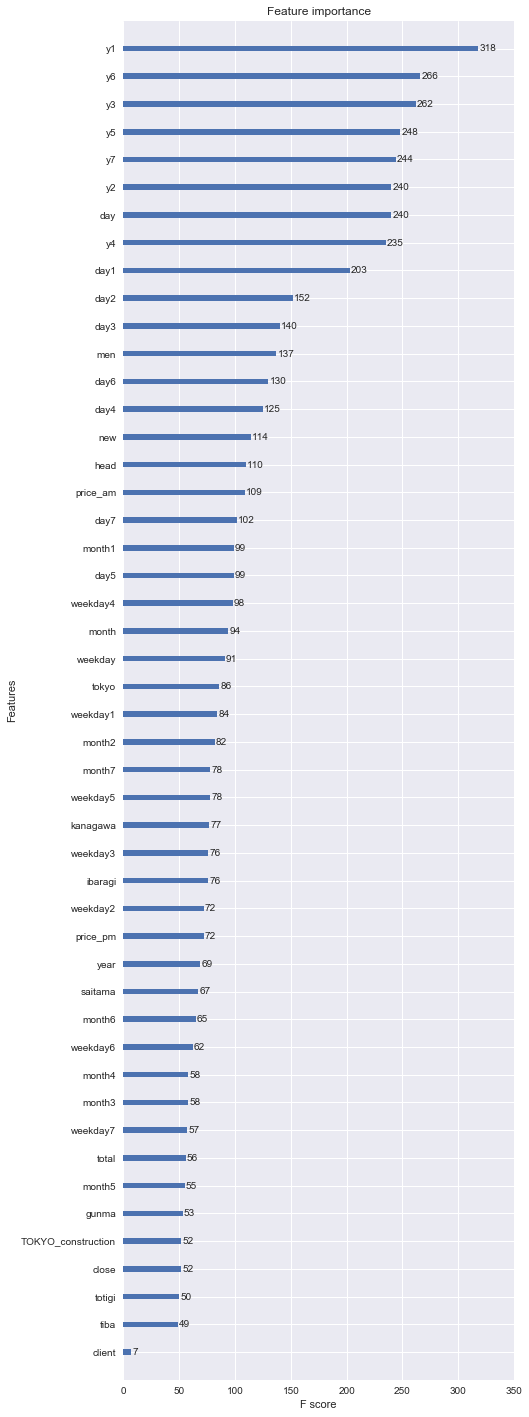

In [81]:
fig, ax = plt.subplots(1,1,figsize=(7,25))
xgb.plot_importance(model,ax=ax)

# 3.Predict

In [82]:
dfeature = xgb.DMatrix(feature.values, label=y.values, feature_names=feature_name)

train_predict = model.predict(dfeature)
print(train_predict.shape)
train_predict

(1728,)


array([ 12.72494698,  14.197855  ,  18.52881241, ...,  80.32791138,
        84.66094208,  81.37226105], dtype=float32)

In [83]:
test_feature = test[feature_name]
test_y=test["y"]
print(test_feature.shape)
test_feature.head()

(366, 48)


,client,close,price_am,price_pm,year,month,day,weekday,y1,y2,y3,y4,y5,y6,y7,month1,day1,weekday1,month2,day2,weekday2,month3,day3,weekday3,month4,day4,weekday4,month5,day5,weekday5,month6,day6,weekday6,month7,day7,weekday7,ibaragi,gunma,totigi,saitama,tiba,tokyo,kanagawa,new,total,men,head,TOKYO_construction
0,1,0,3,3,2015,4,1,2,75.0,87.0,96.0,88.0,95.0,85.0,78.0,3,31,1,3,30,0,3,29,6,3,28,5,3,27,4,3,26,3,3,25,2,1533,1034,1066,3796,3315,7732,4775,68,23251,145,54,107639
1,1,0,2,2,2015,4,2,3,61.0,75.0,87.0,96.0,88.0,95.0,85.0,4,1,2,3,31,1,3,30,0,3,29,6,3,28,5,3,27,4,3,26,3,1533,1034,1066,3796,3315,7732,4775,68,23251,145,54,107639
2,1,0,2,1,2015,4,3,4,60.0,61.0,75.0,87.0,96.0,88.0,95.0,4,2,3,4,1,2,3,31,1,3,30,0,3,29,6,3,28,5,3,27,4,1533,1034,1066,3796,3315,7732,4775,68,23251,145,54,107639
3,1,0,4,3,2015,4,4,5,75.0,60.0,61.0,75.0,87.0,96.0,88.0,4,3,4,4,2,3,4,1,2,3,31,1,3,30,0,3,29,6,3,28,5,1533,1034,1066,3796,3315,7732,4775,68,23251,145,54,107639
4,1,0,2,2,2015,4,5,6,86.0,75.0,60.0,61.0,75.0,87.0,96.0,4,4,5,4,3,4,4,2,3,4,1,2,3,31,1,3,30,0,3,29,6,1533,1034,1066,3796,3315,7732,4775,68,23251,145,54,107639


In [84]:
dtest = xgb.DMatrix(test_feature.values, label=test_y.values, feature_names=feature_name)
test_predict = model.predict(dtest)
print(test_predict.shape)
test_predict

(366,)


array([ 69.00283051,  51.21661758,  56.24677658,  63.43306351,
        64.67254639,  70.1183548 ,  59.10669327,  50.66150284,
        45.43672562,  54.56657028,  72.08611298,  71.7963028 ,
        50.76763535,  49.95064545,  37.8947258 ,  43.59851456,
        44.27075958,  51.77371216,  48.07511902,  43.51516342,
        34.47609711,  38.04829788,  42.954422  ,  55.00481033,
        55.05634308,  55.1737709 ,  54.41049957,  56.49634933,
        61.7443428 ,  58.87493134,  51.51607132,  48.81246948,
        40.50416183,  41.20499802,  37.02915192,  38.1114769 ,
        38.47401428,  39.17751312,  41.5854454 ,  37.19715118,
        28.87666893,  25.5772934 ,  26.58296394,  27.39295197,
        31.12974548,  42.26208878,  40.29405594,  30.57833672,
        29.11918449,  29.47734261,  30.72657013,  38.91375732,
        49.9744873 ,  47.92295837,  42.32829285,  40.61651611,
        46.43897247,  46.79840088,  53.46124268,  55.61394119,
        55.85729599,  45.63938904,  30.09640312,  29.48

In [85]:
tr_diviation = train["y"]-train_predict
tr_mae = np.absolute(tr_diviation).mean()
te_diviation = test["y"]-test_predict
te_mae = np.absolute(te_diviation).mean()
print("trainデータの予想のMAE =",tr_mae)
print("testデータの予想のMAE =",te_mae)

trainデータの予想のMAE = 2.880145031976065
testデータの予想のMAE = 7.1444156534684815


In [86]:
tr_predict = pd.DataFrame(train_predict)
tr_predict.loc[:,"datetime"] = train["datetime"]
tr_predict.columns = ["predict","datetime"]
print(tr_predict.shape)
tr_predict.head()

(1728, 2)


,predict,datetime
0,12.724947,2010-07-08
1,14.197855,2010-07-09
2,18.528812,2010-07-10
3,15.616654,2010-07-11
4,12.306026,2010-07-12


In [87]:
te_predict = pd.DataFrame(test_predict)
te_predict.loc[:,"datetime"] = test["datetime"]
te_predict.columns = ["predict","datetime"]
print(te_predict.shape)
te_predict.head()

(366, 2)


,predict,datetime
0,69.002831,2015-04-01
1,51.216618,2015-04-02
2,56.246777,2015-04-03
3,63.433064,2015-04-04
4,64.672546,2015-04-05


In [88]:
predict = pd.concat((tr_predict,te_predict),axis=0)
predict = predict.reset_index(drop=True).copy()
print(predict.shape)
predict.head()

(2094, 2)


,predict,datetime
0,12.724947,2010-07-08
1,14.197855,2010-07-09
2,18.528812,2010-07-10
3,15.616654,2010-07-11
4,12.306026,2010-07-12


In [89]:
plot = go.Scatter( x=compose.datetime, y=compose['y'])
train_plot = go.Scatter( x=tr_predict["datetime"], y=tr_predict["predict"])
test_plot = go.Scatter( x=te_predict["datetime"], y=te_predict["predict"])
data =[plot,train_plot,test_plot]
plotly.offline.iplot(data)

# 4.提出

提出は2015-3-31までをtrain,2016-4-1~2017-3-31までをtestとする

In [90]:
train =  compose.loc[(compose["timestamp"] < pd.to_datetime("2016-4-1")),:]
test = compose.loc[(compose["timestamp"] >= pd.to_datetime("2016-4-1")),:]
test = test.reset_index(drop=True).copy()


In [91]:
print(train.shape)
print(train.head())
print(train.tail())

(2094, 481)
   index  client  close    datetime  price_am  price_pm     y  timestamp  \
0      7       0      0  2010-07-08        -1        -1  10.0 2010-07-08   
1      8       0      0  2010-07-09        -1        -1  12.0 2010-07-09   
2      9       0      0  2010-07-10        -1        -1  21.0 2010-07-10   
3     10       0      0  2010-07-11        -1        -1  15.0 2010-07-11   
4     11       0      0  2010-07-12        -1        -1  11.0 2010-07-12   

   year  month  day  weekday  elapsed_days period  tintai_bi  baibai_di  \
0  2010      7    8        3             7  2010u      -21.6      -15.8   
1  2010      7    9        4             8  2010u      -21.6      -15.8   
2  2010      7   10        5             9  2010u      -21.6      -15.8   
3  2010      7   11        6            10  2010u      -21.6      -15.8   
4  2010      7   12        0            11  2010u      -21.6      -15.8   

  period1  ibaragi  totigi  gunma  saitama  tiba  tokyo  kanagawa  total  \
0  2

      index  client  close    datetime  price_am  price_pm      y  timestamp  \
2089   2096       1      0  2016-03-27         5         4   94.0 2016-03-27   
2090   2097       1      0  2016-03-28         4         4   86.0 2016-03-28   
2091   2098       1      0  2016-03-29         4         4   98.0 2016-03-29   
2092   2099       1      0  2016-03-30         5         4   99.0 2016-03-30   
2093   2100       1      0  2016-03-31         5         4  105.0 2016-03-31   

      year  month  day  weekday  elapsed_days period  tintai_bi  baibai_di  \
2089  2016      3   27        6          2096  2015b       13.8       18.7   
2090  2016      3   28        0          2097  2015b       13.8       18.7   
2091  2016      3   29        1          2098  2015b       13.8       18.7   
2092  2016      3   30        2          2099  2015b       13.8       18.7   
2093  2016      3   31        3          2100  2015b       13.8       18.7   

     period1  ibaragi  totigi  gunma  saitama  tib

In [92]:
print(test.shape)
print(test.head())
print(test.tail())

(365, 481)
   index  client  close    datetime  price_am  price_pm   y  timestamp  year  \
0      0       1      0  2016-04-01         3         2 NaN 2016-04-01  2016   
1      1       0      0  2016-04-02         5         5 NaN 2016-04-02  2016   
2      2       1      0  2016-04-03         2         2 NaN 2016-04-03  2016   
3      3       1      0  2016-04-04         1         1 NaN 2016-04-04  2016   
4      4       0      0  2016-04-05         1         1 NaN 2016-04-05  2016   

   month  day  weekday  elapsed_days period  tintai_bi  baibai_di period1  \
0      4    1        4          2101  2016u       14.9       18.6  2016Q2   
1      4    2        5          2102  2016u       14.9       18.6  2016Q2   
2      4    3        6          2103  2016u       14.9       18.6  2016Q2   
3      4    4        0          2104  2016u       14.9       18.6  2016Q2   
4      4    5        1          2105  2016u       14.9       18.6  2016Q2   

   ibaragi  totigi  gunma  saitama  tiba  tok

In [93]:
feature = train[feature_name]
y=train["y"]
print(feature.shape)
feature.head()

(2094, 48)


,client,close,price_am,price_pm,year,month,day,weekday,y1,y2,y3,y4,y5,y6,y7,month1,day1,weekday1,month2,day2,weekday2,month3,day3,weekday3,month4,day4,weekday4,month5,day5,weekday5,month6,day6,weekday6,month7,day7,weekday7,ibaragi,gunma,totigi,saitama,tiba,tokyo,kanagawa,new,total,men,head,TOKYO_construction
0,0,0,-1,-1,2010,7,8,3,4.0,14.0,14.0,20.0,20.0,18.0,17.0,7,7,2,7,6,1,7,5,0,7,4,6,7,3,5,7,2,4,7,1,3,1560,1053,1079,3904,3320,7350,4778,85,23044,225,91,76795
1,0,0,-1,-1,2010,7,9,4,10.0,4.0,14.0,14.0,20.0,20.0,18.0,7,8,3,7,7,2,7,6,1,7,5,0,7,4,6,7,3,5,7,2,4,1560,1053,1079,3904,3320,7350,4778,85,23044,225,91,76795
2,0,0,-1,-1,2010,7,10,5,12.0,10.0,4.0,14.0,14.0,20.0,20.0,7,9,4,7,8,3,7,7,2,7,6,1,7,5,0,7,4,6,7,3,5,1560,1053,1079,3904,3320,7350,4778,85,23044,225,91,76795
3,0,0,-1,-1,2010,7,11,6,21.0,12.0,10.0,4.0,14.0,14.0,20.0,7,10,5,7,9,4,7,8,3,7,7,2,7,6,1,7,5,0,7,4,6,1560,1053,1079,3904,3320,7350,4778,85,23044,225,91,76795
4,0,0,-1,-1,2010,7,12,0,15.0,21.0,12.0,10.0,4.0,14.0,14.0,7,11,6,7,10,5,7,9,4,7,8,3,7,7,2,7,6,1,7,5,0,1560,1053,1079,3904,3320,7350,4778,85,23044,225,91,76795


In [94]:
Xtr, Xv, ytr, yv = train_test_split(feature.values, y.values, test_size=0.2, random_state=1)
dtrain = xgb.DMatrix(Xtr, label=ytr, feature_names=feature_name)
dvalid = xgb.DMatrix(Xv, label=yv, feature_names = feature_name)
watchlist = [(dtrain,"train"),(dvalid,"valid")]

xgb_pars = {'min_child_weight': 10, 'eta': 0.05, 'colsample_bytree': 0.3, 'max_depth': 6,
            'subsample': 0.9, 'lambda': 0.7, 'nthread': -1, 'booster': 'gbtree', 
            'eval_metric': 'rmse', 'silent': 1, 'objective': 'reg:linear'}

In [95]:
model = xgb.train(xgb_pars, dtrain, 1000, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=10)

[0]	train-rmse:36.1467	valid-rmse:36.1539
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:22.6403	valid-rmse:22.9587
[20]	train-rmse:14.6647	valid-rmse:15.2951
[30]	train-rmse:10.1153	valid-rmse:11.0665
[40]	train-rmse:7.56027	valid-rmse:8.80214
[50]	train-rmse:6.18572	valid-rmse:7.62154
[60]	train-rmse:5.46201	valid-rmse:7.03473
[70]	train-rmse:5.04163	valid-rmse:6.73742
[80]	train-rmse:4.78202	valid-rmse:6.59893
[90]	train-rmse:4.59638	valid-rmse:6.49723
[100]	train-rmse:4.47446	valid-rmse:6.44479
[110]	train-rmse:4.33339	valid-rmse:6.41616
[120]	train-rmse:4.24674	valid-rmse:6.40838
[130]	train-rmse:4.10963	valid-rmse:6.37555
[140]	train-rmse:4.03426	valid-rmse:6.37923
[150]	train-rmse:3.96031	valid-rmse:6.37486
[160]	train-rmse:3.8746	valid-rmse:6.36552
[170]	train-rmse:3.81637	valid-rmse:6.355
[180]	train-rmse:3.76712	valid-rmse:6.36182
[190]	train-rmse:3.69148	valid-rm

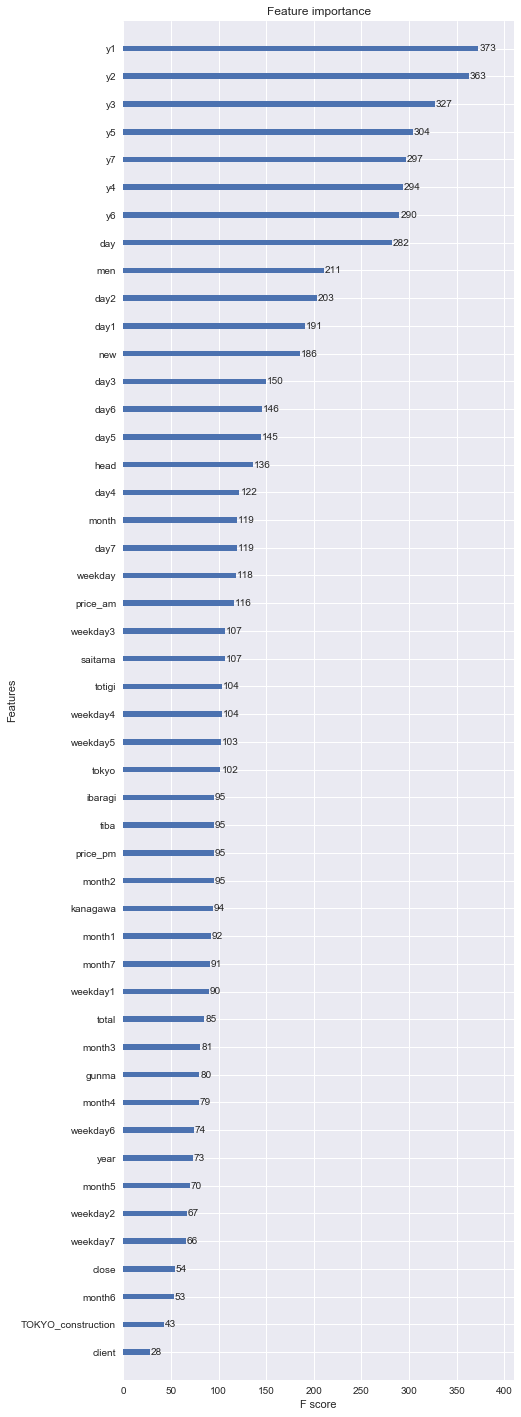

In [96]:
fig, ax = plt.subplots(1,1,figsize=(7,25))
xgb.plot_importance(model,ax=ax)

In [97]:
dfeature = xgb.DMatrix(feature.values, label=y.values, feature_names=feature_name)

train_predict = model.predict(dfeature)
print(train_predict.shape)
train_predict

(2094,)


array([ 11.52096748,  14.21907806,  18.65450478, ...,  91.22875214,
        94.67655945,  97.09857941], dtype=float32)

In [98]:
test_feature = test[feature_name]
test_y=test["y"]
print(test_feature.shape)
test_feature.head()

(365, 48)


,client,close,price_am,price_pm,year,month,day,weekday,y1,y2,y3,y4,y5,y6,y7,month1,day1,weekday1,month2,day2,weekday2,month3,day3,weekday3,month4,day4,weekday4,month5,day5,weekday5,month6,day6,weekday6,month7,day7,weekday7,ibaragi,gunma,totigi,saitama,tiba,tokyo,kanagawa,new,total,men,head,TOKYO_construction
0,1,0,3,2,2016,4,1,4,105.0,99.0,98.0,86.0,94.0,93.0,90.0,3,31,3,3,30,2,3,29,1,3,28,0,3,27,6,3,26,5,3,25,4,1532,1031,1064,3842,3324,7774,4816,63,23383,131,47,107407
1,0,0,5,5,2016,4,2,5,NaN,105.0,99.0,98.0,86.0,94.0,93.0,4,1,4,3,31,3,3,30,2,3,29,1,3,28,0,3,27,6,3,26,5,1532,1031,1064,3842,3324,7774,4816,63,23383,131,47,107407
2,1,0,2,2,2016,4,3,6,NaN,NaN,105.0,99.0,98.0,86.0,94.0,4,2,5,4,1,4,3,31,3,3,30,2,3,29,1,3,28,0,3,27,6,1532,1031,1064,3842,3324,7774,4816,63,23383,131,47,107407
3,1,0,1,1,2016,4,4,0,NaN,NaN,NaN,105.0,99.0,98.0,86.0,4,3,6,4,2,5,4,1,4,3,31,3,3,30,2,3,29,1,3,28,0,1532,1031,1064,3842,3324,7774,4816,63,23383,131,47,107407
4,0,0,1,1,2016,4,5,1,NaN,NaN,NaN,NaN,105.0,99.0,98.0,4,4,0,4,3,6,4,2,5,4,1,4,3,31,3,3,30,2,3,29,1,1532,1031,1064,3842,3324,7774,4816,63,23383,131,47,107407


In [99]:
def y_predict(feature):
    dtest = xgb.DMatrix(feature.values.reshape((1,-1)), feature_names=feature_name)
    test_predict = model.predict(dtest)
    return(test_predict)

In [100]:
def y_copy(i):
        test_feature.loc[i+1,"y7"] = test_feature.loc[i,"y6"]
        test_feature.loc[i+1,"y6"] = test_feature.loc[i,"y5"]
        test_feature.loc[i+1,"y5"] = test_feature.loc[i,"y4"]
        test_feature.loc[i+1,"y4"] = test_feature.loc[i,"y3"]
        test_feature.loc[i+1,"y3"] = test_feature.loc[i,"y2"]
        test_feature.loc[i+1,"y2"] = test_feature.loc[i,"y1"]
        test_feature.loc[i+1,"y1"] = y_predict(test_feature.loc[i,:])

In [101]:
for i in range(test_feature.shape[0]-1):
    y_copy(i)

C:\Users\Mustang8\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [102]:
print(test_feature.shape)
test_feature.tail()


(365, 48)


,client,close,price_am,price_pm,year,month,day,weekday,y1,y2,y3,y4,y5,y6,y7,month1,day1,weekday1,month2,day2,weekday2,month3,day3,weekday3,month4,day4,weekday4,month5,day5,weekday5,month6,day6,weekday6,month7,day7,weekday7,ibaragi,gunma,totigi,saitama,tiba,tokyo,kanagawa,new,total,men,head,TOKYO_construction
360,0,0,5,4,2017,3,27,0,88.674118,89.987328,93.047615,95.470619,94.805954,94.657463,96.346466,3,26,6,3,25,5,3,24,4,3,23,3,3,22,2,3,21,1,3,20,0,1500,1002,1034,3803,3294,7634,4908,62,23175,127,41,120220
361,0,0,4,4,2017,3,28,1,88.279602,88.674118,89.987328,93.047615,95.470619,94.805954,94.657463,3,27,0,3,26,6,3,25,5,3,24,4,3,23,3,3,22,2,3,21,1,1500,1002,1034,3803,3294,7634,4908,62,23175,127,41,120220
362,0,0,3,3,2017,3,29,2,87.394203,88.279602,88.674118,89.987328,93.047615,95.470619,94.805954,3,28,1,3,27,0,3,26,6,3,25,5,3,24,4,3,23,3,3,22,2,1500,1002,1034,3803,3294,7634,4908,62,23175,127,41,120220
363,0,0,4,3,2017,3,30,3,88.694160,87.394203,88.279602,88.674118,89.987328,93.047615,95.470619,3,29,2,3,28,1,3,27,0,3,26,6,3,25,5,3,24,4,3,23,3,1500,1002,1034,3803,3294,7634,4908,62,23175,127,41,120220
364,1,0,5,4,2017,3,31,4,91.601135,88.694160,87.394203,88.279602,88.674118,89.987328,93.047615,3,30,3,3,29,2,3,28,1,3,27,0,3,26,6,3,25,5,3,24,4,1500,1002,1034,3803,3294,7634,4908,62,23175,127,41,120220


In [103]:
dtest = xgb.DMatrix(test_feature.values, label=test_y.values, feature_names=feature_name)
test_predict = model.predict(dtest)
print(test_predict.shape)
test_predict

(365,)


array([  6.83570480e+01,   6.67055817e+01,   6.70874634e+01,
         6.24757652e+01,   6.05396042e+01,   5.90666428e+01,
         5.64979095e+01,   5.44842148e+01,   6.36770363e+01,
         5.94030533e+01,   5.03132744e+01,   4.44893875e+01,
         4.46278114e+01,   4.36791878e+01,   5.09225769e+01,
         5.83885651e+01,   5.24731178e+01,   4.58524742e+01,
         4.33744125e+01,   4.46488419e+01,   4.70368271e+01,
         5.18841896e+01,   6.09686394e+01,   5.99368973e+01,
         5.61624565e+01,   5.17107544e+01,   5.28989716e+01,
         5.89610329e+01,   6.28312492e+01,   7.04557571e+01,
         6.06318665e+01,   4.30860329e+01,   4.05041733e+01,
         3.54560356e+01,   3.44020996e+01,   3.40732880e+01,
         4.39214478e+01,   3.87964134e+01,   3.48839912e+01,
         3.16530094e+01,   2.78387222e+01,   3.23592491e+01,
         4.40836334e+01,   5.30738983e+01,   4.98600159e+01,
         3.58651428e+01,   3.00530987e+01,   2.91253986e+01,
         3.36259956e+01,

In [104]:
tr_diviation = train["y"]-train_predict
tr_mae = np.absolute(tr_diviation).mean()

print("trainデータの予想のMAE =",tr_mae)


trainデータの予想のMAE = 3.016461870205209


In [105]:
tr_predict = pd.DataFrame(train_predict)
tr_predict.loc[:,"datetime"] = train["datetime"]
tr_predict.columns = ["predict","datetime"]
print(tr_predict.shape)
tr_predict.head()

(2094, 2)


,predict,datetime
0,11.520967,2010-07-08
1,14.219078,2010-07-09
2,18.654505,2010-07-10
3,14.870751,2010-07-11
4,12.079359,2010-07-12


In [106]:
te_predict = pd.DataFrame(test_predict)
te_predict.loc[:,"datetime"] = test["datetime"]
te_predict.columns = ["predict","datetime"]
print(te_predict.shape)
te_predict.head()

(365, 2)


,predict,datetime
0,68.357048,2016-04-01
1,66.705582,2016-04-02
2,67.087463,2016-04-03
3,62.475765,2016-04-04
4,60.539604,2016-04-05


In [107]:
predict = pd.concat((tr_predict,te_predict),axis=0)
predict = predict.reset_index(drop=True).copy()
print(predict.shape)
predict.head()

(2459, 2)


,predict,datetime
0,11.520967,2010-07-08
1,14.219078,2010-07-09
2,18.654505,2010-07-10
3,14.870751,2010-07-11
4,12.079359,2010-07-12


In [108]:
plot = go.Scatter( x=compose.datetime, y=compose['y'])
train_plot = go.Scatter( x=tr_predict["datetime"], y=tr_predict["predict"])
test_plot = go.Scatter( x=te_predict["datetime"], y=te_predict["predict"])
data =[plot,train_plot,test_plot]
plotly.offline.iplot(data)

In [109]:
te_predict= te_predict.ix[:,['datetime','predict']]

C:\Users\Mustang8\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix



In [110]:
te_predict.loc[test.loc[:,"close"] ==1,"predict"] =0

In [111]:
te_predict.to_csv("submission.csv",header=None,index=None)